# Task 5 - Learning crowd dynamics

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from helpers.data import load_mi_data
from helpers.plot import plot_pandas_dataset, plot_3d_plot
from helpers.utils import create_delay_embedding, compute_arc_length, integrate_over_periodic_velocity
from helpers.models import RBFRegression


## 1 - Load and plot the data

The dataset `MI_timestep.txt` contains pedestrian utilization data measured at 9 different local areas on the campus over the duration of 7 days.
One day is equal to 2000 timesteps.

### 1.1 Load the data skipping the first 1000 timesteps

In [2]:
df = load_mi_data("data/MI_timesteps.txt", skip_first=1000)
df.shape


(14001, 9)

The shape of the data meets our expectations. Let's take a closer look at the values.

In [3]:
df


,areaDensityCounting-PID5,areaDensityCounting-PID6,areaDensityCounting-PID7,areaDensityCounting-PID8,areaDensityCounting-PID9,areaDensityCounting-PID10,areaDensityCounting-PID11,areaDensityCounting-PID12,areaDensityCounting-PID13
timeStep,,,,,,,,,
1001,0,2,97,7,0,0,5,1,43
1002,0,2,96,7,0,0,5,1,45
1003,0,2,95,6,0,0,5,0,46
1004,0,2,94,6,0,0,4,1,46
1005,0,2,92,6,0,0,5,0,46
...,...,...,...,...,...,...,...,...,...
14997,0,10,95,4,0,0,2,1,39
14998,0,10,94,3,0,0,3,1,39
14999,0,10,93,3,0,1,2,1,40


Let's reset the index to start at 0.

In [4]:
df = df.reset_index(drop=True)


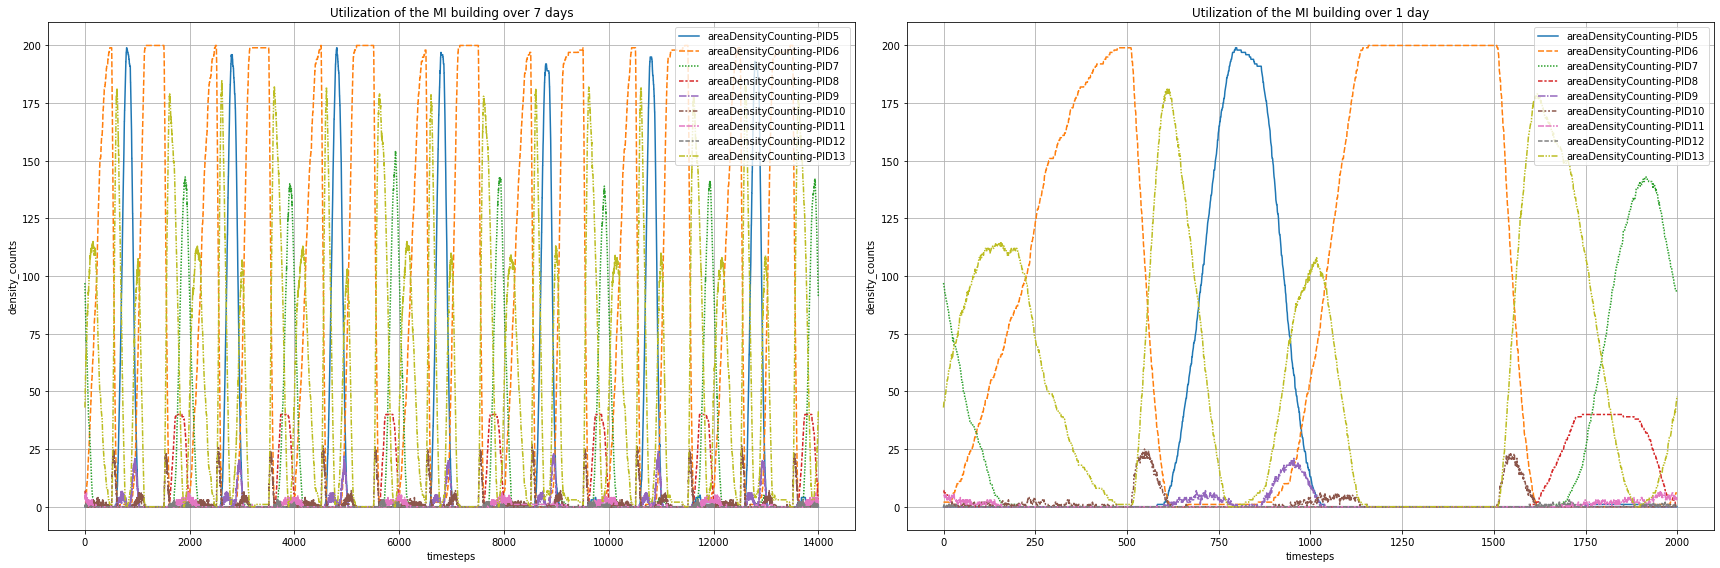

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(24, 8))
axs[0] = plot_pandas_dataset(
    df,
    x_label="timesteps",
    y_label="density_counts",
    title="Utilization of the MI building over 7 days",
    ax=axs[0],
    legend_loc="upper right",
)
axs[0].grid(True)
axs[1] = plot_pandas_dataset(
    df.iloc[:2000, :],
    x_label="timesteps",
    y_label="density_counts",
    title="Utilization of the MI building over 1 day",
    ax=axs[1],
    legend_loc="upper right",
)
axs[1].grid(True)
fig.tight_layout()
fig.savefig("plots/5_dataset.pdf", bbox_inches="tight")


## 2 - Create a reasonable state space for the system

According to Takens, we need 2d + 1 dimensions in our state space in order to capture the full state. Here the dimension d of our manifold is 1 since it is periodic in time and has no further parametric dependencies. Therefore, 3 dimensions are enough for our state space.

### 2.1 Create delay embedding with 350 delays each

In [6]:
M = 13000

delay_embedding = create_delay_embedding(df, num_windows=M, num_delays=350, column_index_to_look_at=[0, 1, 2])
delay_embedding.shape


(13000, 1053)

### 2.2 Convert delay embeddings into 3 - dimensional subspace

In [7]:
from sklearn.decomposition import PCA

SUBSPACE_DIM = 3

pca = PCA(n_components=SUBSPACE_DIM)
state_space = pca.fit_transform(delay_embedding)
state_space.shape


(13000, 3)

## 3. Observe the newly created state space

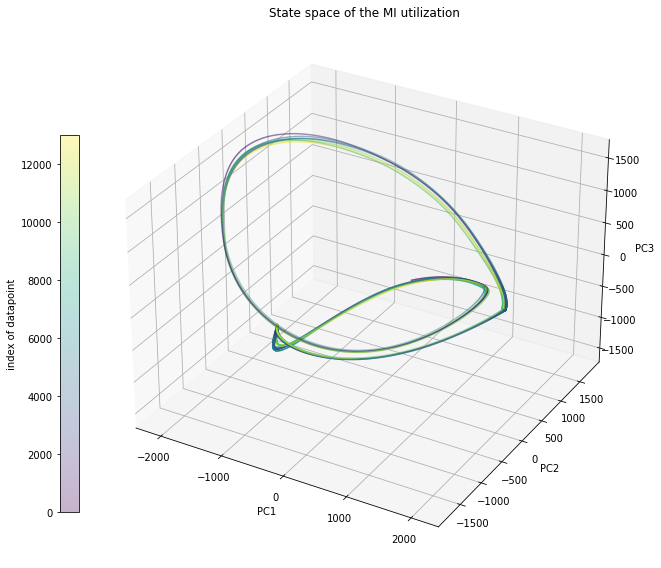

In [8]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection="3d")
plot_3d_plot(
    state_space,
    xlabel="PC1",
    ylabel="PC2",
    zlabel="PC3",
    title="State space of the MI utilization",
    ax=ax,
    fig=fig,
    title_colorbar="index of datapoint",
    c=np.arange(state_space.shape[0]),
    s=0.5,
    alpha=0.3,
)
fig.tight_layout()
fig.savefig("plots/5_state_space.pdf", bbox_inches="tight")


One can the the periodic nature of the state space, as the original state space is also periodic.

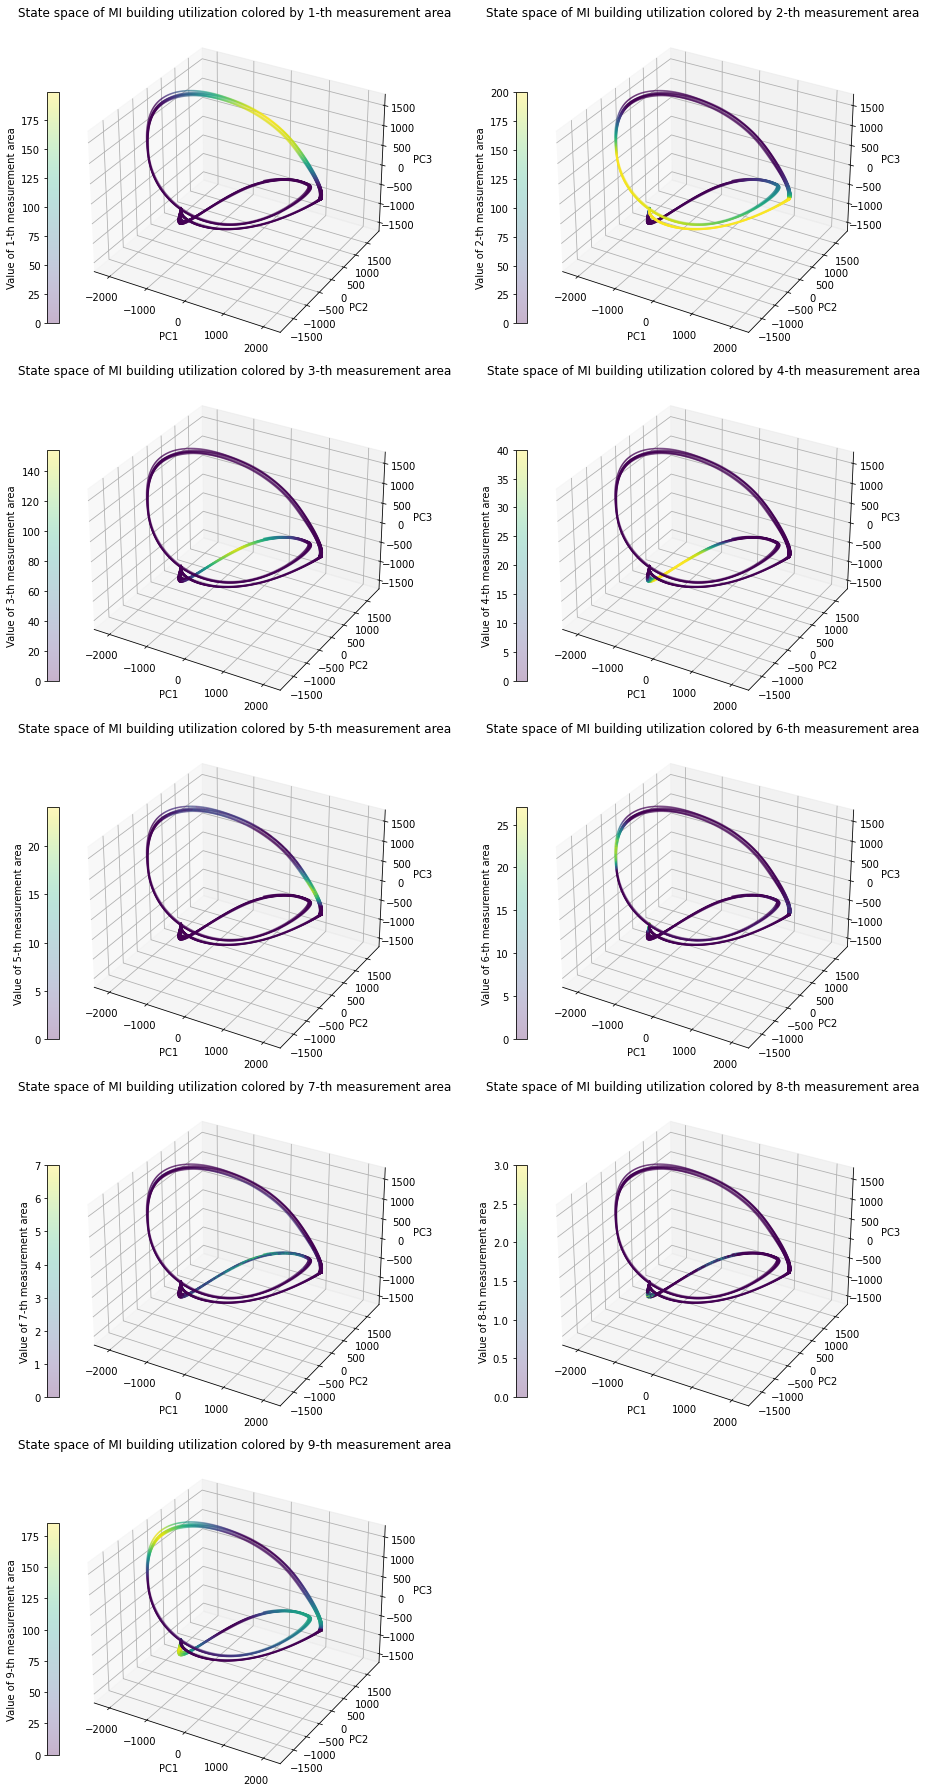

In [9]:
NUM_PLOTS = 9
NUM_COLS = 2
NUM_ROWS = NUM_PLOTS // NUM_COLS + 1

fig = plt.figure(figsize=(NUM_COLS * 7, NUM_ROWS * 5))

for i in range(0, NUM_PLOTS):
    ax = fig.add_subplot(NUM_ROWS, NUM_COLS, i + 1, projection="3d")
    ax.set_aspect("auto")
    ax = plot_3d_plot(
        state_space,
        xlabel="PC1",
        ylabel="PC2",
        zlabel="PC3",
        title=f"State space of MI building utilization colored by {i+1}-th measurement area",
        ax=ax,
        fig=fig,
        title_colorbar=f"Value of {i+1}-th measurement area",
        c=df.iloc[:M, i],
        s=0.5,
        alpha=0.3,
    )

fig.tight_layout()
fig.savefig("plots/5_state_space_by_measurement_area.pdf", bbox_inches="tight")


## 4 - Compute dynamics of state space

### 4.1 Compute the arclength

In [10]:
state_space_arc_length = compute_arc_length(state_space)

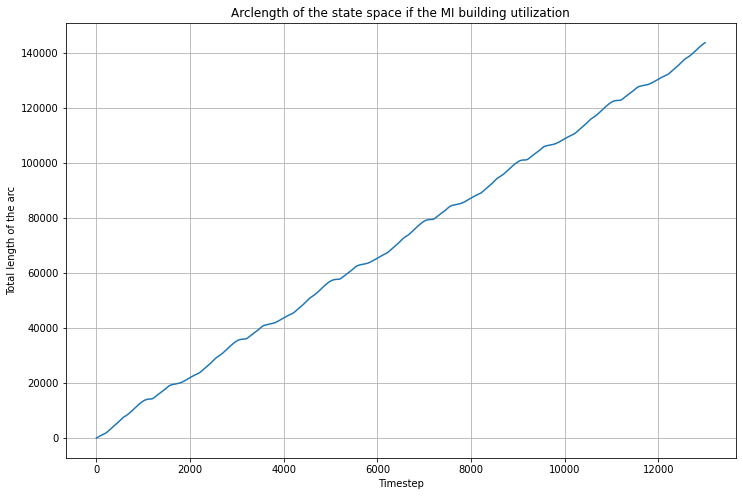

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(state_space_arc_length)
ax.set_xlabel("Timestep")
ax.set_ylabel("Total length of the arc")
ax.set_title("Arclength of the state space if the MI building utilization")
ax.grid(True)

### 4.2 Estimate the change in arclength over time = velocity

In [12]:
state_space_arc_velocity = np.gradient(state_space_arc_length)

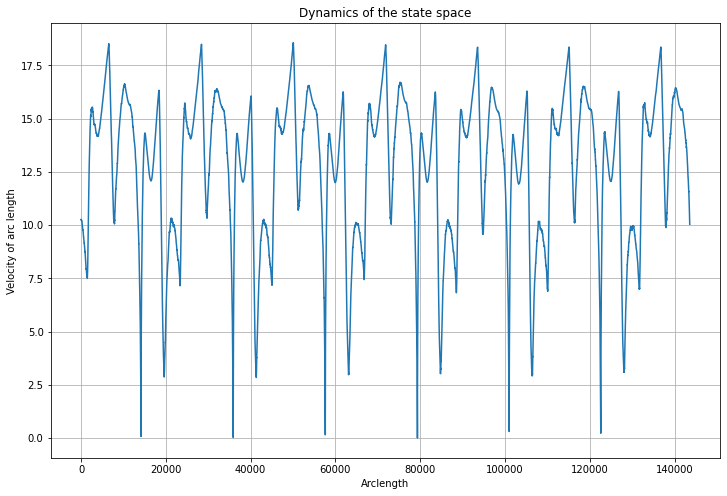

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(state_space_arc_length, state_space_arc_velocity)
ax.set_xlabel("Arclength")
ax.set_ylabel("Velocity of arc length")
ax.set_title("Dynamics of the state space")
ax.grid(True)


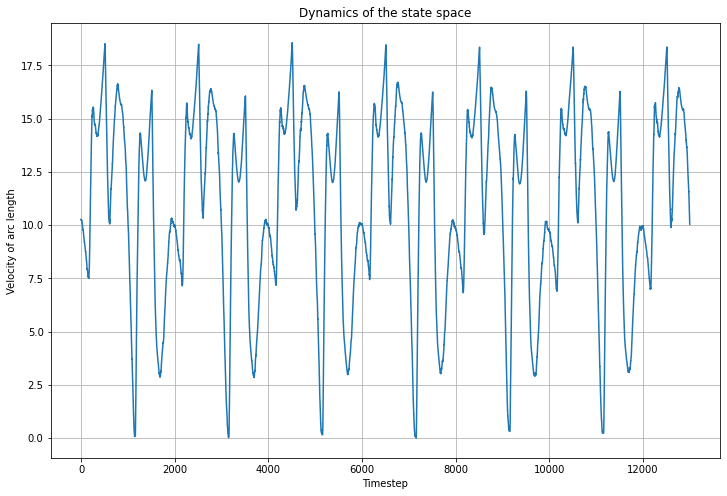

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(state_space_arc_velocity)
ax.set_xlabel("Timestep")
ax.set_ylabel("Velocity of arc length")
ax.set_title("Dynamics of the state space")
ax.grid(True)


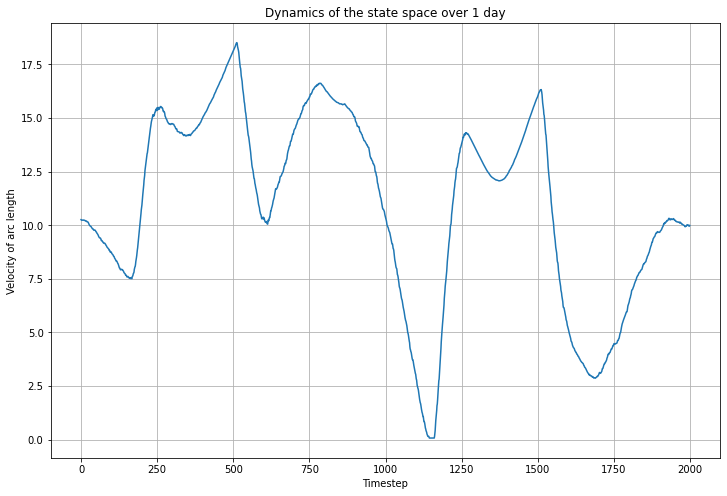

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(state_space_arc_velocity[:2000])
ax.set_xlabel("Timestep")
ax.set_ylabel("Velocity of arc length")
ax.set_title("Dynamics of the state space over 1 day")
ax.grid(True)


## 5. Predict arc length for the next 14 days

In [16]:
arc_length_14_days = integrate_over_periodic_velocity(state_space_arc_velocity[:2000], 14 * 2000)
arc_length_14_days.shape

(28000,)

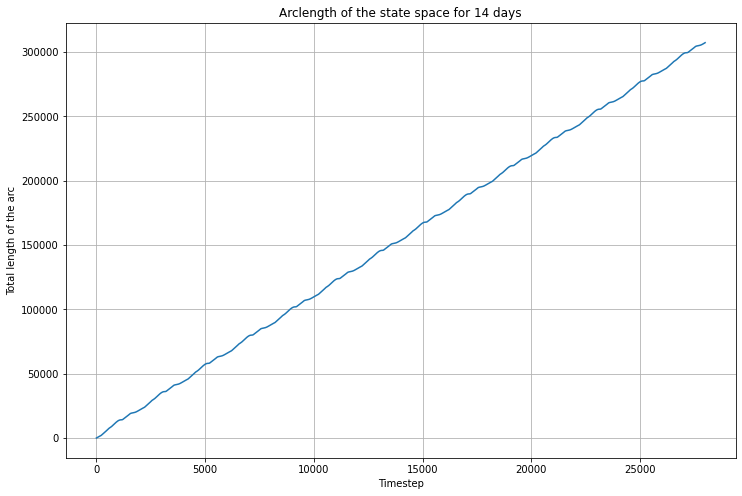

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(arc_length_14_days)
ax.set_xlabel("Timestep")
ax.set_ylabel("Total length of the arc")
ax.set_title("Arclength of the state space for 14 days")
ax.grid(True)


## 6. Fit mapping between arclength space and utilization of first measurement zone

### 6.1 Inspect the relationship

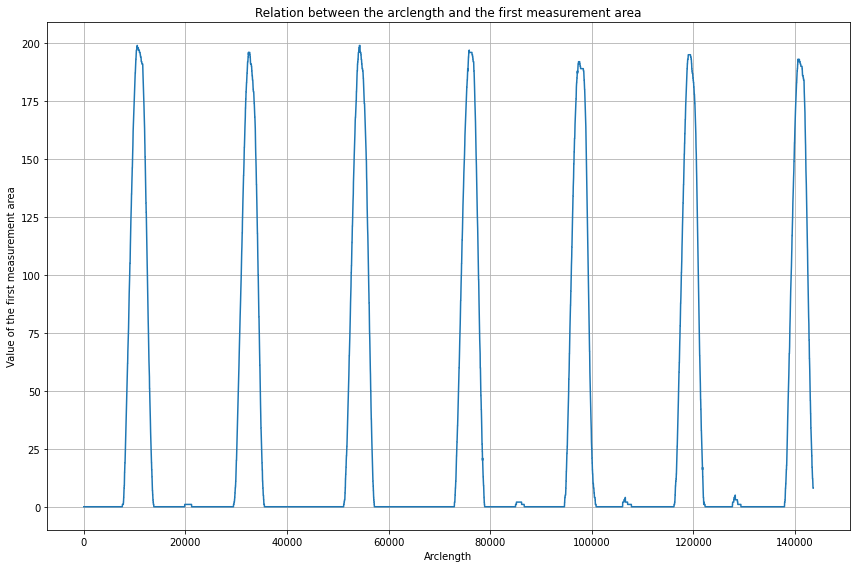

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(state_space_arc_length, df.iloc[:state_space_arc_length.shape[0], 0])
ax.set_xlabel("Arclength")
ax.set_ylabel("Value of the first measurement area")
ax.set_title("Relation between the arclength and the first measurement area")
ax.grid(True)
fig.tight_layout()

### 6.2 Use RBF Regression to approximate the relation

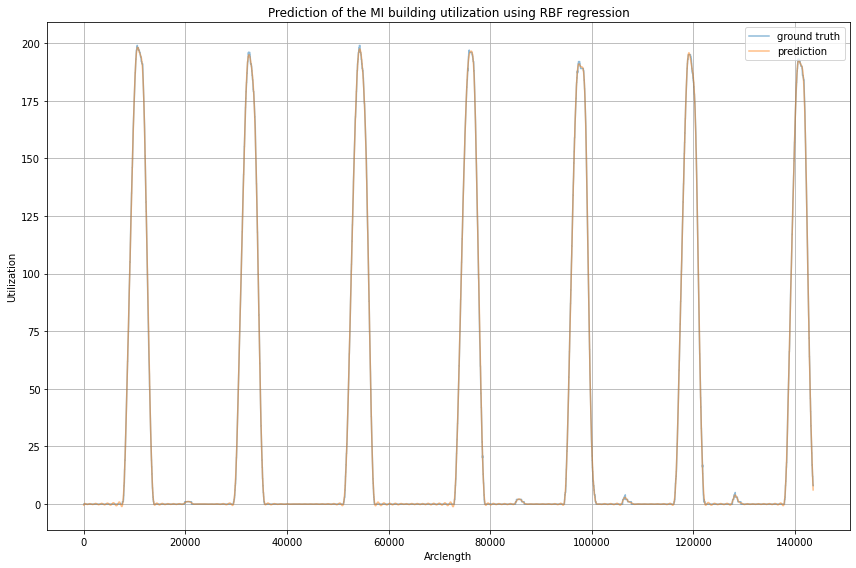

In [26]:
rbf = RBFRegression(eps=M / 10, L=500)
rbf.fit(state_space_arc_length, df.iloc[:state_space_arc_length.shape[0], 0])
pred = rbf.predict(state_space_arc_length)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(state_space_arc_length, df.iloc[:state_space_arc_length.shape[0], 0], alpha=0.5, label="ground truth")
ax.plot(state_space_arc_length, pred, alpha=0.5, label="prediction")
ax.legend()
ax.set_title("Prediction of the MI building utilization using RBF regression")
ax.set_xlabel("Arclength")
ax.set_ylabel("Utilization")
ax.grid(True)
fig.tight_layout()


## 7. Use the learnt mapping to predict the utilization for the next 14 days

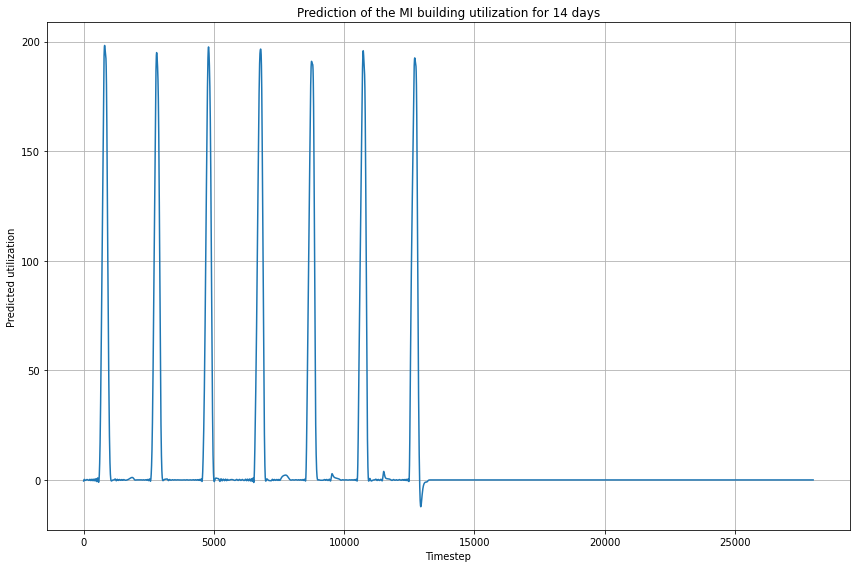

In [29]:
pred = rbf.predict(arc_length_14_days)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(pred)
ax.set_xlabel("Timestep")
ax.set_ylabel("Predicted utilization")
ax.set_title("Prediction of the MI building utilization for 14 days")
ax.grid(True)
fig.tight_layout()
